<a href="https://colab.research.google.com/github/KevenMartins/neural-nerwork-apps/blob/main/ClassificacaoImagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dados, metadados = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete66WU0Q/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete66WU0Q/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadados

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    

In [4]:
dados_treinamento, dados_teste = dados['train'], dados['test']

In [5]:
nome_classes = metadados.features['label'].names

In [6]:
nome_classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
#Normalizar os dados (Passar de 0-255 a 0-1)

def normalizar(imagens, etiquetas):
  imagens = tf.cast(imagens, tf.float32)
  imagens /= 255 #passar de 0-255 a 0-1
  return imagens, etiquetas

#Normalizar os atos de treinameno e teste com a função que fizemos
dados_treinamento = dados_treinamento.map(normalizar)
dados_teste = dados_teste.map(normalizar) 

#Adicionar ao cache (usar memória em vez de disco, treina mais rápido)
dados_treinamento = dados_treinamento.cache()
dados_teste = dados_teste.cache()

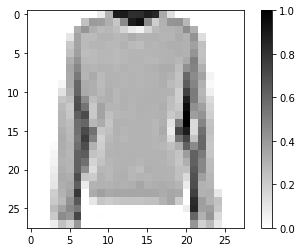

In [8]:
#Mostrar uma imagem dos dados te teste, neste momento mostramos a primeira
for imagem, etiqueta in dados_treinamento.take(1):
  break
imagem = imagem.numpy().reshape((28,28))#Redimencionar, material de tensor, veremos mais tarde

import matplotlib.pyplot as plt

#Desenhar 
plt.figure()
plt.imshow(imagem,cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


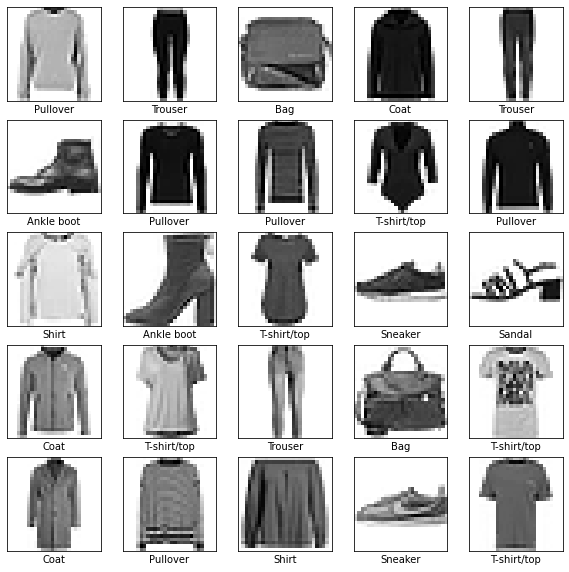

In [9]:
plt.figure(figsize=(10,10))
for i, (imagem, etiqueta) in enumerate(dados_treinamento.take(25)):
  imagem = imagem.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagem, cmap=plt.cm.binary)
  plt.xlabel(nome_classes[etiqueta])
plt.show()

In [10]:
#Criar o modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # - branco e preto
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax), #Para redes de classificação
])

In [11]:
#Compilar o medelo

modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
num_ej_treinamento = metadados.splits["train"].num_examples
num_ej_testes = metadados.splits["test"].num_examples

In [13]:
print(num_ej_treinamento)
print(num_ej_testes)

60000
10000


In [14]:
TAMANHO_LOTE = 32

dados_treinamento = dados_treinamento.repeat().shuffle(num_ej_treinamento).batch(TAMANHO_LOTE)
dados_teste = dados_teste.batch(TAMANHO_LOTE)

In [15]:
import math

#Treinar
historial = modelo.fit(dados_treinamento, epochs=5, steps_per_epoch=math.ceil(num_ej_treinamento/TAMANHO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 10s 2ms/step - loss: 0.5165 - accuracy: 0.8189
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3835 - accuracy: 0.8618
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3500 - accuracy: 0.8716
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3253 - accuracy: 0.8798
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3081 - accuracy: 0.8858


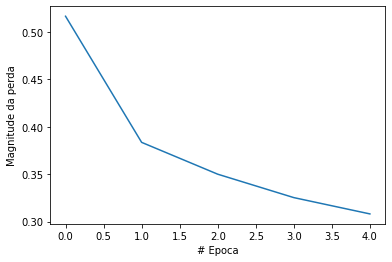

In [16]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitude da perda")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 93ms/step


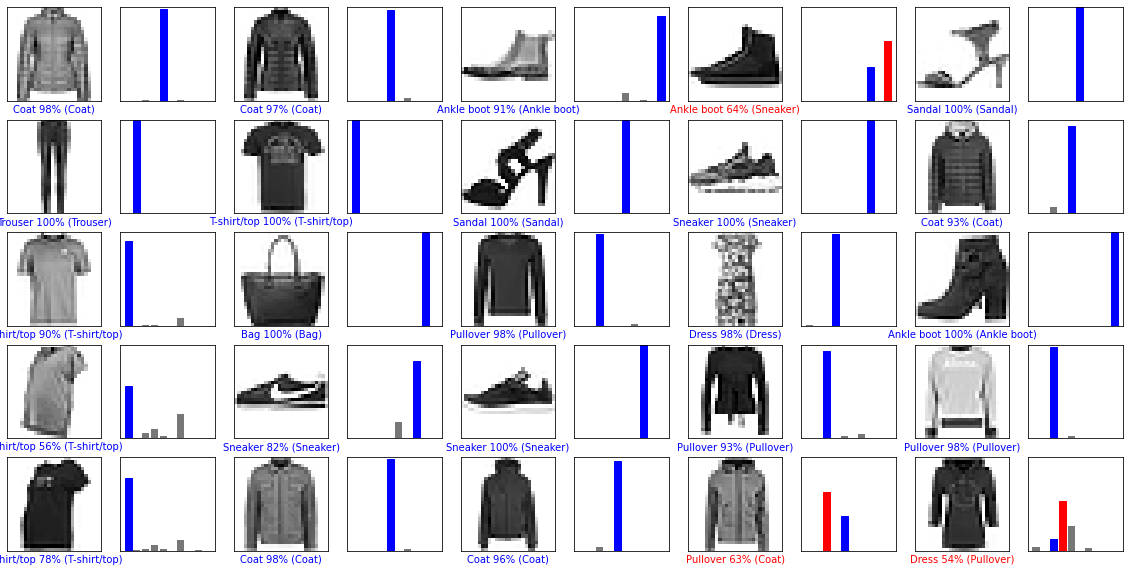

In [17]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_teste, etiquetas_teste in dados_teste.take(1):
  imagenes_teste = imagenes_teste.numpy()
  etiquetas_teste = etiquetas_teste.numpy()
  predicciones = modelo.predict(imagenes_teste)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nome_classes[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nome_classes[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_teste, imagenes_teste)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_teste)

In [24]:
#Testar uma única imagem
imagem = imagenes_teste[3] # Como a variável images_test só tem o que foi colocado no bloco anterior heheh
imagem = np.array([imagem])
prediccion = modelo.predict(imagem)

print("Prediccion: " + nome_classes[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 62ms/step
Prediccion: Ankle boot
